## Load replay buffer

In [2]:
import pickle
from src.utils import load_replay_buffer

TASK_NAME="sac_circle_rotation_task_0"
N_SAMPLES:int=100_000
KERNEL_DIM=1
EPSILON_BALL = 0.025
EPSILON_LEVEL_SET = 0.0025

LEARN_KERNEL_BASES: bool=True


replay_buffer_name:str=TASK_NAME+"_replay_buffer.pkl"
kernel_bases_name:str=TASK_NAME+"_kernel_bases.pkl"


replay_buffer_task_1= load_replay_buffer(replay_buffer_name, N_steps=N_SAMPLES)

## Pointwise kernel bases of reward function

- We have $R(p)=n$ where $p=(s,a)$ and $n$ is the real-valued reward value.
- Learn the component of $G$ that acts on $S$ and the component of $G$ that acts on $A$ independently.

In [3]:
from src.learning.symmetry_discovery.differential.kernel_approx import pointwise_kernel_approx


ps=replay_buffer_task_1["observations"]
ns=replay_buffer_task_1["rewards"]

print("Shape of ps: ", ps.shape, " (should be (N_steps, |S|))")
print("Shape of ns: ", ns.shape, " (should be (N_steps))")

if LEARN_KERNEL_BASES:
    kernel_samples=pointwise_kernel_approx(p=ps, n=ns, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)
    with open(kernel_bases_name, 'wb') as f:
        pickle.dump(kernel_samples, f)
else:
    with open(kernel_bases_name, 'rb') as f:
        kernel_samples = pickle.load(f)  

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:32: UserWarning: TODO: Dimension of kernel should be actively inferred, not passed as an argument.
  warnings.warn("TODO: Dimension of kernel should be actively inferred, not passed as an argument.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
INFO:root:Computing neighborhood of samples via kdtree...


Shape of ps:  torch.Size([100000, 2])  (should be (N_steps, |S|))
Shape of ns:  torch.Size([100000])  (should be (N_steps))


Compute Point-Wise Bases via PCA...: 100%|██████████| 100000/100000 [00:08<00:00, 11256.60it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 92.94% of samples (good)
  - one tangent vector for 2.01% of samples (okay)
  - no tangent vector for 5.05% of samples (not good, no basis).


## Learn Grassman Subspace

In [22]:
import torch
import torch.nn.functional as F

def kernel_weights(p_query, ps, bandwidth):
    dists = torch.norm(ps - p_query, dim=1)
    weights = torch.exp(-dists**2 / (2 * bandwidth**2))
    return weights / weights.sum()

def log_map_grassmann(V_ref, V):
    # V_ref, V: both (d, k), orthonormal bases as column vectors
    M = V_ref.T @ V  # (k, k)
    U, S, Vt = torch.linalg.svd(M)
    S = torch.clamp(S, -1.0 + 1e-6, 1.0 - 1e-6)
    Theta = torch.arccos(S)
    sin_Theta = torch.sin(Theta)
    sin_Theta[sin_Theta == 0] = 1e-6
    A = (V - V_ref @ M) @ torch.diag(Theta / sin_Theta)
    return A  # (d, k) in tangent space at V_ref

def exp_map_grassmann(V_ref, A):
    U, S, Vt = torch.linalg.svd(A, full_matrices=False)
    Theta = S
    sin_Theta = torch.sin(Theta)
    cos_Theta = torch.cos(Theta)
    term1 = V_ref @ (Vt.T @ torch.diag(cos_Theta) @ Vt)
    term2 = U @ torch.diag(sin_Theta) @ Vt
    V_new = term1 + term2
    return torch.linalg.qr(V_new, mode='reduced').Q  # (d, k)

In [23]:
def smooth_subspace(p_query, ps, kernel_samples, bandwidth, n_neighbors=20):
    """
    p_query: Tensor of shape (d,)
    ps: Tensor of shape (N, d)
    kernel_samples: dict {i: V_i}, each V_i of shape (d, k)
    bandwidth: float
    n_neighbors: number of closest samples to use
    Returns: (d, k) smoothed orthonormal basis
    """
    d = ps.shape[1]
    all_indices = torch.tensor(list(kernel_samples.keys()))
    ps_subset = ps[all_indices]  # (N, d)

    # Find n_neighbors closest points
    dists = torch.norm(ps_subset - p_query, dim=1)
    nn_dists, nn_indices = torch.topk(dists, k=n_neighbors, largest=False)
    selected_indices = all_indices[nn_indices]

    # Kernel weights
    weights = torch.exp(-nn_dists**2 / (2 * bandwidth**2))
    weights = weights / weights.sum()

    # Gather and orthonormalize bases
    V_bases = [
        torch.linalg.qr(kernel_samples[i], mode='reduced').Q  # (d, k)
        for i in selected_indices.tolist()
    ]

    # Use the nearest basis as reference
    V_ref = V_bases[0]  # (d, k)

    # Log maps and weighted tangent sum
    tangent_sum = torch.zeros_like(V_ref)
    for w, V_i in zip(weights, V_bases):
        W = log_map_grassmann(V_ref, V_i)  # (d, k)
        tangent_sum += w * W

    # Project back via exp map
    V_smooth = exp_map_grassmann(V_ref, tangent_sum)  # (d, k)
    return V_smooth


p_query = torch.tensor([0.7, 0.2])  # Example query point in the same space as ps

V_smooth = smooth_subspace(p_query, ps, kernel_samples, bandwidth=0.5, n_neighbors=20)

In [24]:
V_smooth

tensor([[-0.9415],
        [ 0.3369]])

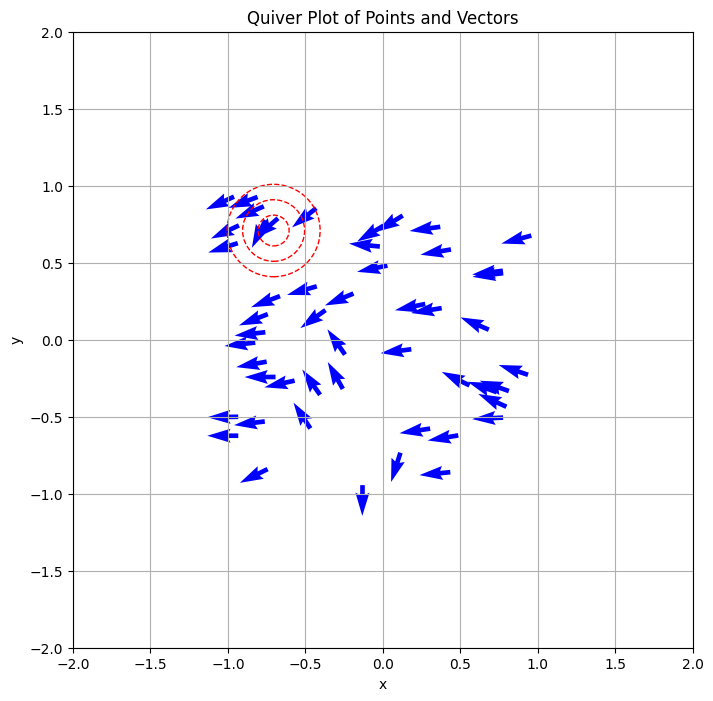

In [31]:
import numpy as np

import matplotlib.pyplot as plt

# Sample 50 points uniformly in the 2D plane
num_points = 50
x = np.random.uniform(-1, 1, num_points)
y = np.random.uniform(-1, 1, num_points)
points = np.stack([x, y], axis=1)

# Feed points into smooth_subspace and collect vectors
vectors = []
for point in points:
    p_query = torch.tensor(point, dtype=torch.float32)
    V_smooth = smooth_subspace(p_query, ps, kernel_samples, bandwidth=0.5, n_neighbors=20)
    vectors.append(V_smooth.numpy())  # Extract the first row of the smoothed subspace

vectors = np.array(vectors)
# Add circles around the specified goal point

# Plot points and vectors using quiver
plt.figure(figsize=(8, 8))
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue')


goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.5, 1, 1.5]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quiver Plot of Points and Vectors')
plt.grid()
plt.show()

In [8]:
import torch as th
from src.learning.symmetry_discovery.differential.diff_generator import DiffGenerator

g_0=th.randn(KERNEL_DIM, ps.shape[1], ps.shape[1], requires_grad=True)
optimizer= th.optim.Adam([g_0], lr=5e-5)
N_steps=10_000

linear_kernel=DiffGenerator(g_0=g_0, p=ps, bases=kernel_samples, n_steps=N_steps, optimizer=optimizer, batch_size=256)
linear_kernel.optimize()

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:195: UserWarning: TODO: only learns linear Kernel distributions.
  warnings.warn("TODO: only learns linear Kernel distributions.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:196: UserWarning: TODO: Implement early stopping in Kernel learning.
  warnings.warn("TODO: Implement early stopping in Kernel learning.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:58: UserWarning: TODO: Differential Generator is not Normalized During Training
  warnings.warn("TODO: Differential Generator is not Normalized During Training")
Loss: 2.0795e+02: 100%|██████████| 10000/10000 [00:21<00:00, 470.47it/s]


tensor([[[-1.0462, -0.0700],
         [-0.6525,  0.9691]]], requires_grad=True)

In [5]:
linear_kernel.g

tensor([[[ 0.0775,  0.2187],
         [-0.5813, -0.4310]]], requires_grad=True)